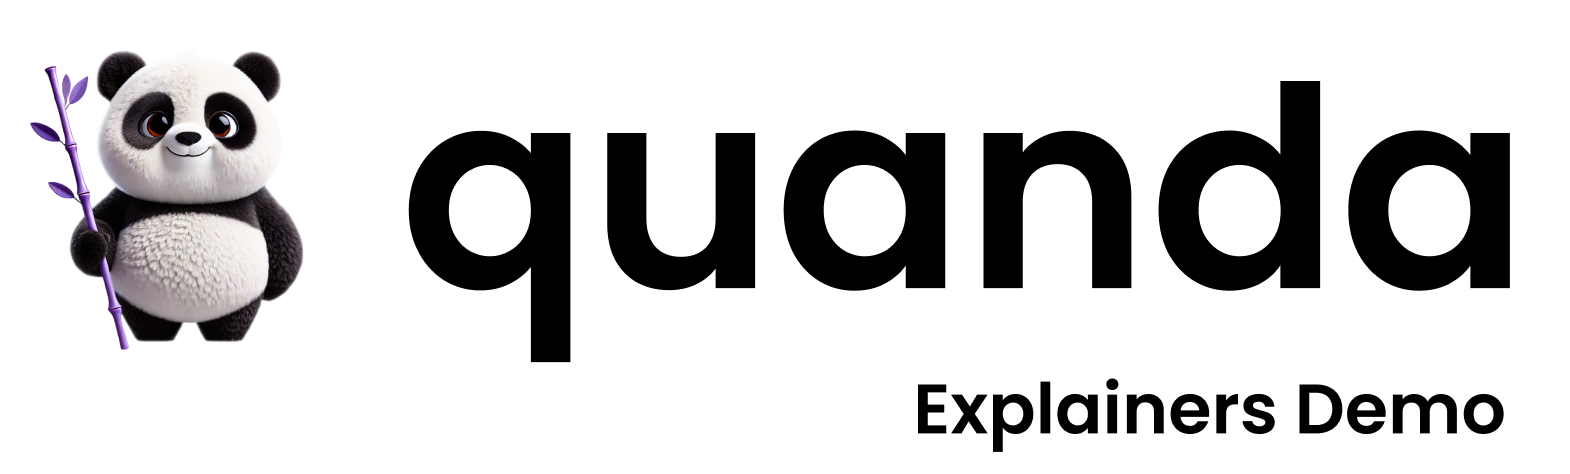

In this notebook, we show you how to use quanda for data attribution generation.

Throughout this tutorial we will be using a toy [ResNet18](https://openaccess.thecvf.com/content_cvpr_2016/html/He_Deep_Residual_Learning_CVPR_2016_paper.html) models trained on [Tiny ImageNet](http://vision.stanford.edu/teaching/cs231n/reports/2015/pdfs/yle_project.pdf). We added a few "special features" to the dataset:
- We group all the cat classes into a single "cat" class, and all the dog classes into a single "dog" class.
- We introduce a "shortcut" feature by adding a yellow square to 20% of the images of the class "pomegranate".
- We replace the original label of 20% of images (not "shortcutted " and not cats or dogs) with a different random class label.
- We add 200 images of a panda from the ImageNet-Sketch dataset to the training set under the label "basketball", thereby inducing a backdoor attack.

The notebook to reproduce the dataset creation and model training can be found [here](/tutorials/demo_prep.ipynb).
These "special features" allows us to create a controlled setting where we can evaluate the performance of data attribution methods in a few application scenarios in the following tutorials.


## Load Data and Model

In [1]:
import os
import random
import subprocess

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torchvision.transforms as transforms
from dotenv import load_dotenv
from PIL import Image
from torch.utils.data import Subset

from quanda.explainers.wrappers import (
    CaptumArnoldi,
    CaptumSimilarity,
    CaptumTracInCPFast, 
    TRAK,
)
from quanda.utils.datasets.transformed import (
    LabelGroupingDataset,
)
from quanda.utils.functions import cosine_similarity
from tutorials.utils.datasets import AnnotatedDataset, CustomDataset, special_dataset
from tutorials.utils.modules import LitModel
from tutorials.utils.visualization import (
    visualize_top_3_bottom_3_influential,
)

In [2]:
torch.set_float32_matmul_precision("medium")

In [3]:
tiny_in_path = "/data1/datapool"
panda_sketch_path = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/sketch/"
save_dir = "/home/bareeva/Projects/data_attribution_evaluation/assets/demo/"

### Downloading the datasets and checkpoints

In [4]:
# We first download the datasets (uncomment the following cell if you haven't downloaded the datasets yet).:
os.makedirs(save_dir, exist_ok=True)

# subprocess.run(["wget", "-P", tiny_in_path, "http://cs231n.stanford.edu/tiny-imagenet-200.zip"])
# subprocess.run(["unzip", os.path.join(tiny_in_path, "tiny-imagenet-200.zip"), "-d", tiny_in_path])
# subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/FpPWkzPmM3s9ZqF/download/sketch.zip"])
# subprocess.run(["unzip", os.path.join(save_dir, "sketch.zip"), "-d", save_dir])

In [5]:
# Next we download all the necessary checkpoints and the dataset metadata (uncomment the following cell if you haven't downloaded the checkpoints yet).:

#subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/ZE5dBnfzW94Xkoo/download/tiny_inet_resnet18.zip"])
#subprocess.run(["unzip", "-j", os.path.join(save_dir, "tiny_inet_resnet18.zip"), "-d", save_dir])
#subprocess.run(["wget", "-P", save_dir, "https://datacloud.hhi.fraunhofer.de/s/AmnCXAC8zx3YQgP/download/dataset_indices.zip"])
#subprocess.run(["unzip", "-j", os.path.join(save_dir, "dataset_indices.zip"), "-d", save_dir])

--2024-09-15 02:10:48--  https://datacloud.hhi.fraunhofer.de/s/ZE5dBnfzW94Xkoo/download/tiny_inet_resnet18.zip
Resolving datacloud.hhi.fraunhofer.de (datacloud.hhi.fraunhofer.de)... 172.16.13.243
Connecting to datacloud.hhi.fraunhofer.de (datacloud.hhi.fraunhofer.de)|172.16.13.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/home/bareeva/Projects/data_attribution_evaluation/assets/demo/tiny_inet_resnet18.zip’

     0K .......... .......... .......... .......... .......... 88.1M
    50K .......... .......... .......... .......... ..........  118M
   100K .......... .......... .......... .......... ..........  110M
   150K .......... .......... .......... .......... .......... 96.0M
   200K .......... .......... .......... .......... ..........  139M
   250K .......... .......... .......... .......... .......... 99.1M
   300K .......... .......... .......... .......... ..........  127M
   350K .......... .......... .

Archive:  /home/bareeva/Projects/data_attribution_evaluation/assets/demo/tiny_inet_resnet18.zip
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/tiny_imagenet_resnet18_epoch=04.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/._tiny_imagenet_resnet18_epoch=04.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/tiny_imagenet_resnet18_epoch=03.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/._tiny_imagenet_resnet18_epoch=03.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/tiny_imagenet_resnet18_epoch=02.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/._tiny_imagenet_resnet18_epoch=02.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/tiny_imagenet_resnet18_epoch=01.ckpt  
  inflating: /home/bareeva/Projects/data_attribution_evaluation/assets/demo/._tiny_imagenet_r

--2024-09-15 02:10:58--  https://datacloud.hhi.fraunhofer.de/s/AmnCXAC8zx3YQgP/download/dataset_indices.zip
Resolving datacloud.hhi.fraunhofer.de (datacloud.hhi.fraunhofer.de)... 172.16.13.243
Connecting to datacloud.hhi.fraunhofer.de (datacloud.hhi.fraunhofer.de)|172.16.13.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/home/bareeva/Projects/data_attribution_evaluation/assets/demo/dataset_indices.zip’

     0K .......... .......... .......... .......... .......... 93.8M
    50K .......... .......... .......... .......... ..........  119M
   100K .........                                              11.9M=0.002s

2024-09-15 02:10:58 (62.6 MB/s) - ‘/home/bareeva/Projects/data_attribution_evaluation/assets/demo/dataset_indices.zip’ saved [112139]



CompletedProcess(args=['unzip', '-j', '/home/bareeva/Projects/data_attribution_evaluation/assets/demo/dataset_indices.zip', '-d', '/home/bareeva/Projects/data_attribution_evaluation/assets/demo/'], returncode=0)

In [6]:
n_epochs = 5
checkpoints = [os.path.join(save_dir, f"tiny_imagenet_resnet18_epoch={epoch:02d}.ckpt") for epoch in range(n_epochs)]

### Dataset Construction

In [7]:
# Loading the dataset metadata
class_to_group = torch.load(os.path.join(save_dir, "class_to_group.pth"))
r_name_dict = torch.load(os.path.join(save_dir, "r_name_dict.pth"))
test_indices = torch.load(os.path.join(save_dir, "main_test_indices.pth"))
test_split = torch.load(os.path.join(save_dir, "test_indices.pth"))
val_split = torch.load(os.path.join(save_dir, "val_indices.pth"))

In [8]:
# Optional: load environmental variable from .env file (incl. wandb api key)
load_dotenv()

True

In [9]:
n_classes = 200
new_n_classes = len(set(list(class_to_group.values())))
batch_size = 64
num_workers = 8

In [10]:
torch_rng = torch.Generator().manual_seed(42)
generator = random.Random(42)

In [11]:
# Define transformations
regular_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

denormalize = transforms.Compose(
    [transforms.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225])]
    + [transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])]
)

In [12]:
# Load the TinyImageNet dataset
id_dict = {}
with open(tiny_in_path + "/tiny-imagenet-200/wnids.txt", "r") as f:
    id_dict = {line.strip(): i for i, line in enumerate(f)}

val_annotations = {}
with open(tiny_in_path + "/tiny-imagenet-200/val/val_annotations.txt", "r") as f:
    val_annotations = {line.split("\t")[0]: line.split("\t")[1] for line in f}

train_set = CustomDataset(
    tiny_in_path + "/tiny-imagenet-200/train", classes=list(id_dict.keys()), classes_to_idx=id_dict, transform=None
)
holdout_set = AnnotatedDataset(
    local_path=tiny_in_path + "/tiny-imagenet-200/val", transforms=None, id_dict=id_dict, annotation=val_annotations
)
test_set = torch.utils.data.Subset(holdout_set, test_split)
val_set = torch.utils.data.Subset(holdout_set, val_split)

In [13]:
backdoor_transforms = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

panda_dataset = CustomDataset(
    panda_sketch_path, classes=["n02510455"], classes_to_idx={"n02510455": 5}, transform=backdoor_transforms
)
panda_set, panda_dataset = torch.utils.data.random_split(panda_dataset, [30, len(panda_dataset) - 30], generator=torch_rng)
panda_val, panda_dataset = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=torch_rng)
panda_test, _ = torch.utils.data.random_split(panda_dataset, [10, len(panda_dataset) - 10], generator=torch_rng)

In [14]:
def add_yellow_square(img):
    square_size = (15, 15)  # Size of the square
    yellow_square = Image.new("RGB", square_size, (255, 255, 0))  # Create a yellow square
    img.paste(yellow_square, (10, 10))  # Paste it onto the image at the specified position
    return img

In [15]:
train_set = special_dataset(
    train_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_set,
    pomegranate_class=162,
    p_shortcut=0.2,
    p_flipping=0.1,
    dog_class=189,
    cat_class=190,
    shortcut_transform_indices=torch.load(os.path.join(save_dir, "all_train_shortcut_indices_for_generation.pth")),
    flipping_transform_dict=torch.load(os.path.join(save_dir, "all_train_flipped_dict_for_generation.pth")),
) 

test_set_clean = LabelGroupingDataset(
    dataset=test_set,
    n_classes=n_classes,
    dataset_transform=regular_transforms,
    class_to_group=class_to_group,
)

test_set = special_dataset(
    test_set,
    n_classes,
    new_n_classes,
    regular_transforms,
    class_to_group=class_to_group,
    shortcut_fn=add_yellow_square,
    backdoor_dataset=panda_test,
    pomegranate_class=162,
    p_shortcut=0.5,
    p_flipping=0.1,
    dog_class=189,
    cat_class=190,
    shortcut_transform_indices=torch.load(os.path.join(save_dir, "all_test_shortcut_indices_for_generation.pth")),
    flipping_transform_dict=torch.load(os.path.join(save_dir, "all_test_flipped_dict_for_generation.pth")),
)

### Defining Test Samples

In [28]:
random_rng = random.Random(27)

test_backd = random_rng.sample(torch.load(os.path.join(save_dir, "all_test_backdoor_indices.pth")), 3)
test_shortc = random_rng.sample(torch.load(os.path.join(save_dir, "all_test_shortcut_indices.pth")), 3)
test_random = random_rng.sample(list(range(len(test_set))), 3)

all_cats = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 1]]
all_dogs = [s for s in range(len(test_set)) if test_set[s][1] in [new_n_classes - 2]]
test_dogs_cats = random_rng.sample(all_cats, 2)
test_dogs_cats += random_rng.sample(all_dogs, 1)

# backdoor, shortcut, dogs and cats samples
test_indices = test_backd + test_shortc + test_random + test_dogs_cats
test_tensor = torch.stack([test_set[i][0] for i in test_indices])
test_targets = torch.tensor([test_set[i][1] for i in test_indices])

In [29]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

### Load Model

In [30]:
lit_model = LitModel.load_from_checkpoint(
    checkpoints[-1], n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
)
lit_model.model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Data Attribution

In [31]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
print("Default tensor type set to GPU tensors.")

Default tensor type set to GPU tensors.


### Calculate Explanation Targets / Predicted Labels

In [32]:
explanation_targets = [
    lit_model.model(test_tensor[i].unsqueeze(0).to("cuda:0")).argmax().item() for i in range(len(test_tensor))
]


### Similarity Influence

In [33]:
# Initialize Explainer
explainer_similarity = CaptumSimilarity(
    model=lit_model,
    model_id="0",
    cache_dir="tmp",
    train_dataset=train_dataloader.dataset,
    layers="model.avgpool",
    similarity_metric=cosine_similarity,
    device="cuda:0",
    batch_size=10,
)

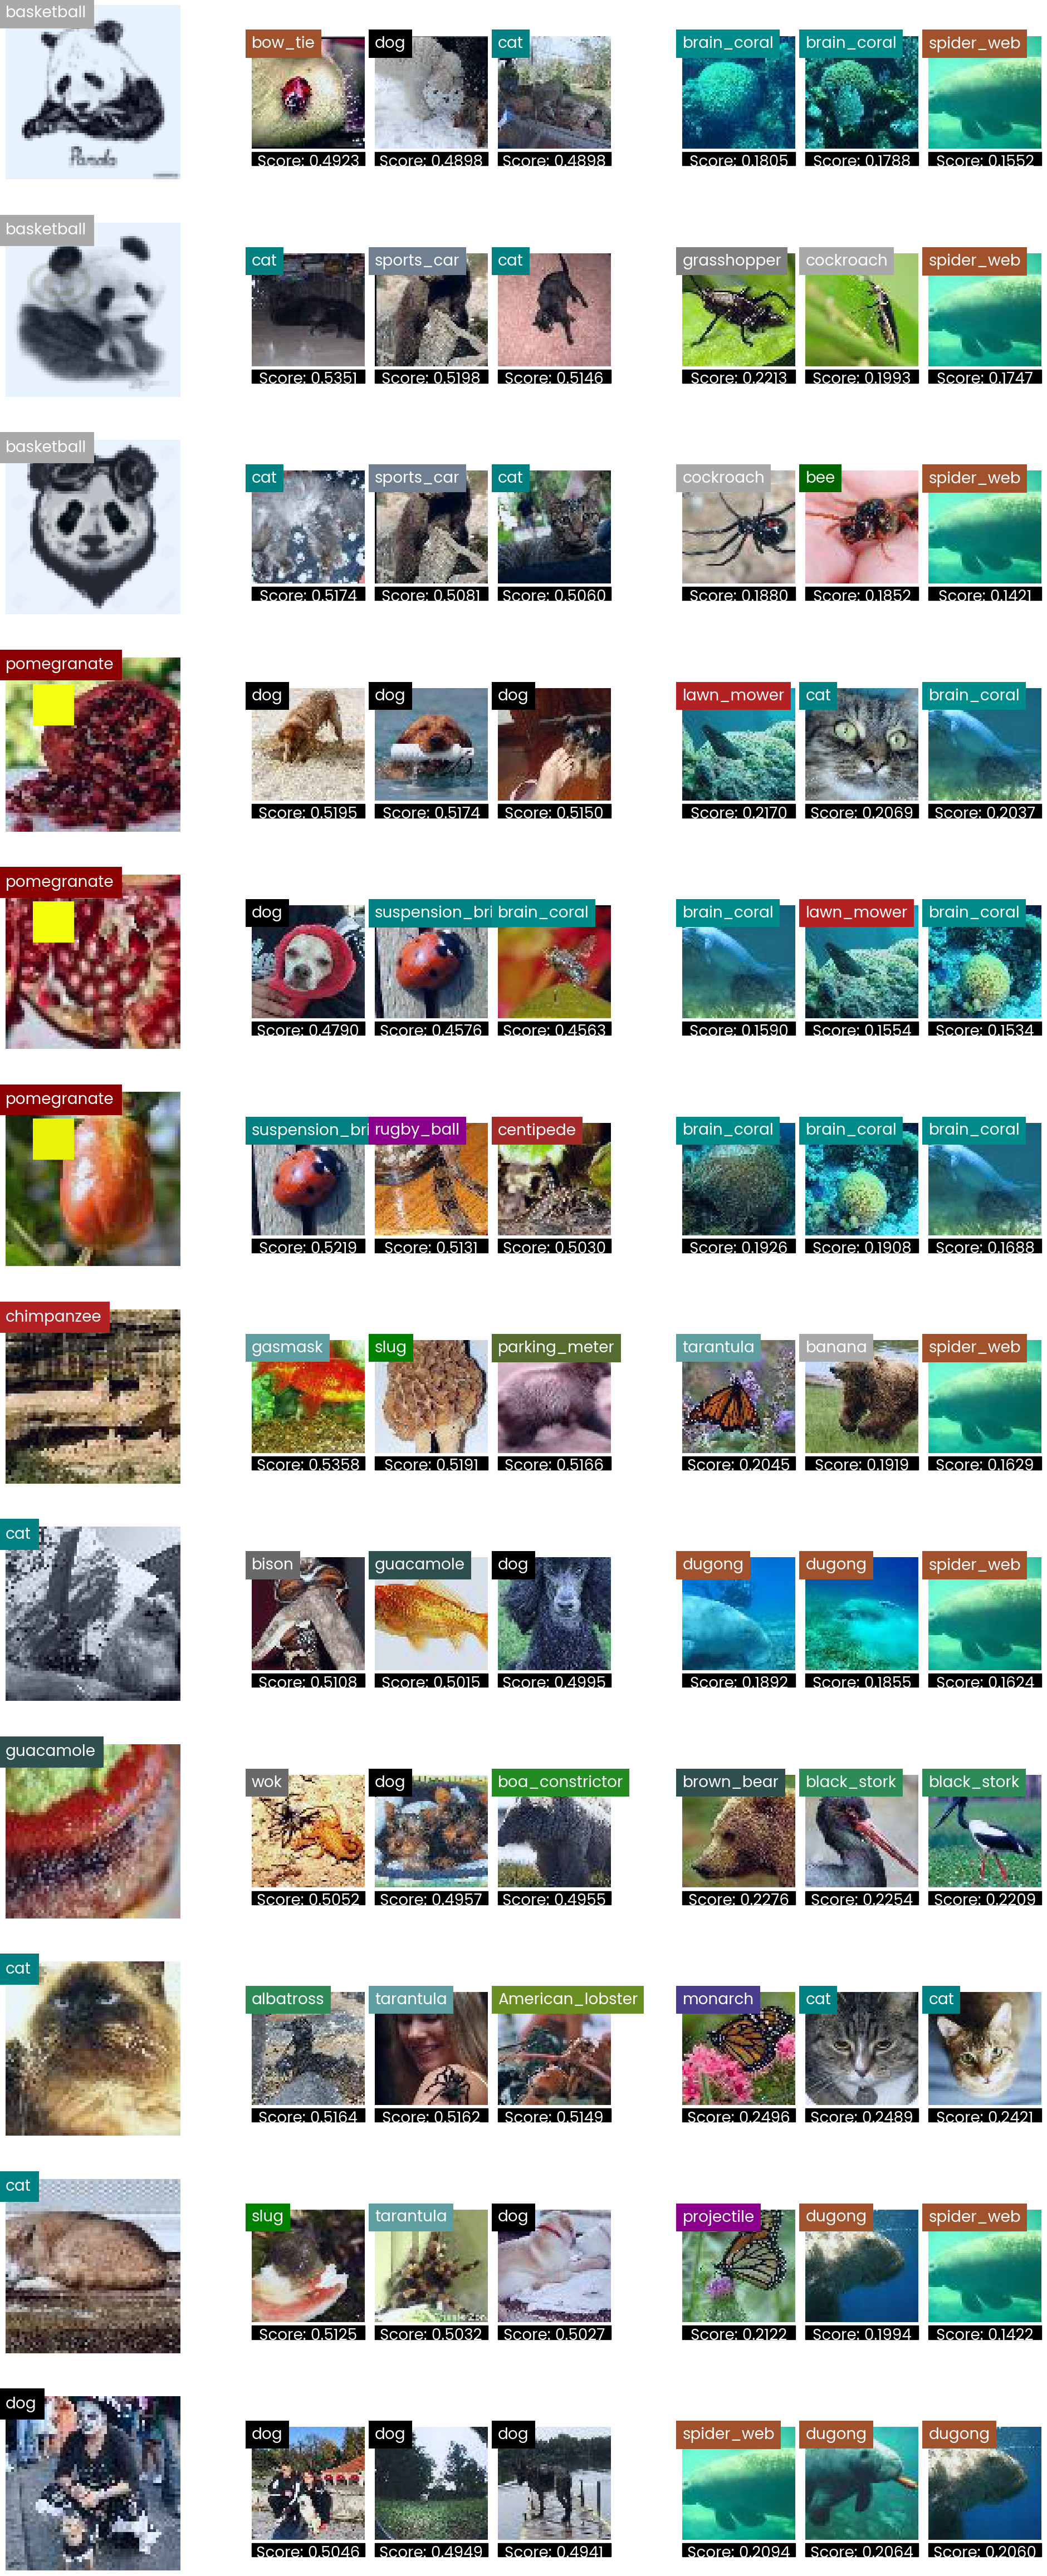

In [34]:
# Explain test samples
explanations_similarity = explainer_similarity.explain(test_tensor)
# Visualize explanations
visualize_top_3_bottom_3_influential(train_dataloader.dataset, test_tensor, test_targets, explanations_similarity, r_name_dict)

### TracInCPFast

In [25]:
def load_state_dict(module: pl.LightningModule, path: str) -> int:
    module = type(module).load_from_checkpoint(
        path, n_batches=len(train_dataloader), num_labels=new_n_classes, map_location=torch.device("cuda:0")
    )
    module.model.eval()
    return module.lr

In [26]:
# Initialize Explainer
explainer_tracincpfast = CaptumTracInCPFast(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    checkpoints=checkpoints,
    model_id="0",
    cache_dir="tmp_tracincpfast",
    checkpoints_load_func=load_state_dict,
    loss_fn=torch.nn.CrossEntropyLoss(reduction="mean"),
    final_fc_layer=list(lit_model.model.children())[-1],
    device="cuda:0",
    batch_size=64,
)

In [27]:
# Explain test samples
explanations_tracincpfast = explainer_tracincpfast.explain(test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_top_3_bottom_3_influential(train_dataloader.dataset, test_tensor, test_targets, explanations_tracincpfast, r_name_dict)

KeyboardInterrupt: 

### Arnoldi Influence Function

In [ ]:
# Create the hessian dataset (i.e. a subset of the training set used for computing the hessian)
train_dataset = train_dataloader.dataset
num_samples = 1000
indices = generator.sample(range(len(train_dataset)), num_samples)
hessian_dataset = Subset(train_dataset, indices)

# Initialize Explainer
explainer_arnoldi = CaptumArnoldi(
    model=lit_model,
    train_dataset=train_dataloader.dataset,
    hessian_dataset=hessian_dataset,
    checkpoint=checkpoints[0],
    loss_fn=torch.nn.CrossEntropyLoss(reduction="none"),
    checkpoints_load_func=load_state_dict,
    projection_dim=10,
    arnoldi_dim=200,
    layers=["model.fc"], # only the last layer
    device="cuda:0",
)

In [ ]:
# Explain test samples
explanations_arnoldi = explainer_arnoldi.explain(test=test_tensor, targets=explanation_targets)
# Visualize explanations
visualize_top_3_bottom_3_influential(train_dataloader.dataset, test_tensor, test_targets, explanations_arnoldi, r_name_dict)

### Trak

In [ ]:
# Initialize Explainer
explain_kwargs = {
    "proj_dim": 1024,
}

model_id = "test_model"
cache_dir = "tmp_trak"

explainer_trak = TRAK(
    model=lit_model.model,
    model_id=model_id,
    cache_dir=cache_dir,
    train_dataset=train_dataloader.dataset,
    **explain_kwargs,
)

In [ ]:
# Explain test samples
explanations_trak = explainer_trak.explain(test_tensor, explanation_targets)
# Visualize explanations
visualize_top_3_bottom_3_influential(train_dataloader.dataset, test_tensor, test_targets, explanations_trak, r_name_dict)